## Forecasting taxi orders

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

### Instructions for project execution

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.

### Description of data

The data is in the `taxi.csv` file. The number of orders is in the '*num_orders*' column.

# 1. Preparation

In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
print(data.index.is_monotonic)
print(data.info())
data

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


***Change the data type to DataFrame and make dates instead of indexes. After we check whether the dates are in order.***

In [3]:
data = data.resample('1H').sum() # 1 hour interval with sum of values
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


***Set the interval to 1 hour with the sum of the values***

# 2. Analysis

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,169.18
2018-08-31 20:00:00,154,169.86
2018-08-31 21:00:00,159,169.66


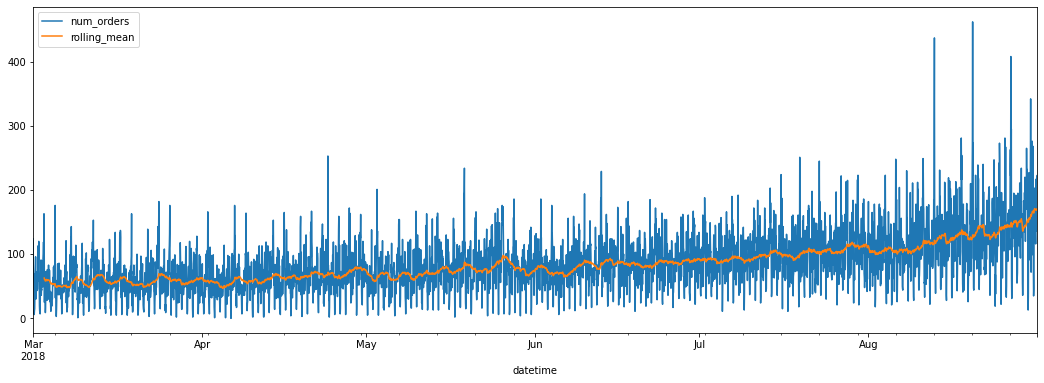

In [4]:
data['rolling_mean'] = data.rolling(50).mean() # Скользящее среднее с окном 50
data.plot(figsize=(18, 6))
data

***Moving Average (Checking the trend)***

In [5]:
data = data.drop(['rolling_mean'], axis=1)

***Remove unnecessary column***

Text(0.5, 1.0, 'Seasonal')

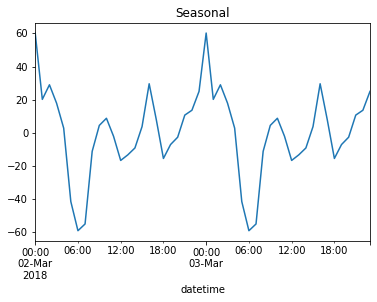

In [6]:
decomposed = seasonal_decompose(data)

decomposed.seasonal['2018-03-02':'2018-03-03'].plot()
plt.title('Seasonal')

***Number of orders drops at night (People sleep)***

Text(0.5, 1.0, 'Trend')

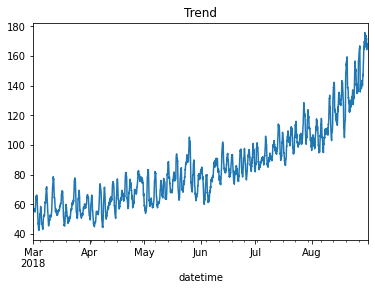

In [7]:
decomposed.trend.plot()
plt.title('Trend')

***The trend shows that the number of orders is growing (The company is developing and capturing the market)***

<AxesSubplot:xlabel='datetime'>

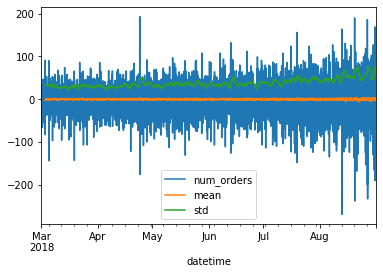

In [8]:
data_1 = data - data.shift() # shift the value to make the row stationary
data_1['mean'] = data_1['num_orders'].rolling(50).mean()
data_1['std'] = data_1['num_orders'].rolling(50).std()
data_1.plot()

***shift of values is necessary for the series to become stationary***

# 3. Education

In [9]:
def make_features(data, max_lag, rolling_mean_size):
     # four new calendar attributes: year, month, day and day of the week
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # lagging values. max_lag, which will set the maximum lag size.
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # moving average
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 150, 150)
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,162.0,105.0,123.0,123.0,158.0,182.0,150.0,130.0,63.0,154.173333
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,155.0,162.0,105.0,123.0,123.0,158.0,182.0,150.0,130.0,154.660000
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,174.0,155.0,162.0,105.0,123.0,123.0,158.0,182.0,150.0,154.820000


***We set four new calendar features, the maximum backlog size and a moving average with different sizes. Their value affects the quality of the model.***

In [11]:
train, valid, test = np.split(data.sample(frac=1, random_state=12345),
                                 [int(.6*len(data)), int(.8*len(data))])

train = train.dropna()
valid = valid.dropna()
test = test.dropna()
# variables for features and target feature
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print(train.shape)
print(valid.shape)
print(test.shape)


(2563, 156)
(846, 156)
(857, 156)


In [12]:
train

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-19 15:00:00,48,2018,3,19,0,50.0,45.0,39.0,83.0,69.0,...,35.0,64.0,69.0,50.0,40.0,34.0,75.0,53.0,44.0,56.893333
2018-08-01 13:00:00,93,2018,8,1,2,72.0,90.0,75.0,131.0,66.0,...,104.0,53.0,70.0,102.0,86.0,142.0,138.0,80.0,39.0,109.366667
2018-06-29 04:00:00,95,2018,6,29,4,91.0,100.0,87.0,161.0,107.0,...,40.0,60.0,93.0,126.0,155.0,118.0,172.0,109.0,147.0,89.173333
2018-03-30 02:00:00,45,2018,3,30,4,85.0,91.0,109.0,60.0,63.0,...,36.0,57.0,75.0,182.0,148.0,105.0,78.0,143.0,78.0,59.773333
2018-05-10 14:00:00,90,2018,5,10,3,52.0,52.0,73.0,130.0,54.0,...,96.0,55.0,97.0,67.0,34.0,75.0,83.0,40.0,57.0,65.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-19 15:00:00,93,2018,4,19,3,38.0,42.0,45.0,50.0,72.0,...,71.0,95.0,88.0,57.0,47.0,47.0,69.0,104.0,46.0,64.573333
2018-06-18 05:00:00,74,2018,6,18,0,102.0,144.0,101.0,118.0,182.0,...,31.0,21.0,55.0,83.0,75.0,111.0,109.0,142.0,87.0,87.886667
2018-05-07 03:00:00,105,2018,5,7,0,154.0,89.0,154.0,146.0,73.0,...,25.0,77.0,84.0,55.0,74.0,81.0,77.0,85.0,88.0,65.986667


***Dividing the Dataset into test and training samples***

In [13]:
%%time
model = LinearRegression()
model = model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_valid)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)


MSE: 544.7421690307328
RMSE: 23.339712273949154
CPU times: user 205 ms, sys: 259 ms, total: 464 ms
Wall time: 364 ms


In [14]:
%%time

model1 = CatBoostRegressor(iterations=100, learning_rate=1, depth = 13)
# Fit model
model1.fit(features_train, target_train, verbose=10) 
predictions_valid1 = model1.predict(features_valid)
mse1 = mean_squared_error(target_valid, predictions_valid1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

0:	learn: 29.1362094	total: 3.68s	remaining: 6m 4s
10:	learn: 9.0871563	total: 40.5s	remaining: 5m 27s
20:	learn: 3.3406547	total: 1m 16s	remaining: 4m 47s
30:	learn: 0.9446478	total: 1m 51s	remaining: 4m 7s
40:	learn: 0.3962470	total: 2m 26s	remaining: 3m 31s
50:	learn: 0.1488113	total: 3m 1s	remaining: 2m 54s
60:	learn: 0.0571957	total: 3m 37s	remaining: 2m 18s
70:	learn: 0.0226802	total: 4m 12s	remaining: 1m 43s
80:	learn: 0.0082509	total: 4m 49s	remaining: 1m 7s
90:	learn: 0.0035421	total: 5m 24s	remaining: 32.1s
99:	learn: 0.0013570	total: 5m 56s	remaining: 0us
MSE: 805.2878653723236
RMSE: 28.377594425397014
CPU times: user 5min 54s, sys: 1.06 s, total: 5min 55s
Wall time: 5min 56s


In [15]:
%%time
model4 = RandomForestRegressor(n_estimators=100, max_depth = 13)
model4.fit(features_train, target_train) 
predictions_valid4 = model4.predict(features_valid)
mse4 = mean_squared_error(target_valid, predictions_valid4)
print("MSE:", mse4)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 531.4455346754569
RMSE: 23.05310249566112
CPU times: user 17 s, sys: 75.9 ms, total: 17.1 s
Wall time: 17.1 s


**Train models**

# 4. Testing

In [16]:
%%time
predictions_test = model.predict(features_test)
mse = mean_squared_error(target_test, predictions_test)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)

MSE: 696.549409276546
RMSE: 26.39222251491045
CPU times: user 33.7 ms, sys: 20.1 ms, total: 53.8 ms
Wall time: 28.1 ms


In [17]:
%%time
predictions_test4 = model4.predict(features_test)
mse4 = mean_squared_error(target_test, predictions_test4)
print("MSE:", mse4)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 653.3839381792938
RMSE: 25.561375905441665
CPU times: user 40.5 ms, sys: 8.05 ms, total: 48.5 ms
Wall time: 38.3 ms


In [18]:
%%time
predictions_test1 = model1.predict(features_test)
mse1 = mean_squared_error(target_test, predictions_test1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

MSE: 968.8415708283916
RMSE: 31.12621998939787
CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 11.9 ms


**Check on a test set**

# 5. Conclusion

| Params/Model | Linear Regression | catboost | Random Forest |
| :------------ | :-------------: |:-------------: |:-------------: |
| Study Time | 752ms | 5min 9s | 23.8s |
| Run time | 2.59ms|103ms| 11.8ms|
| | | | | | |
| Quality on Training Set (RMSE) | 22.1 |5.1 | 9.6 |
| Quality on test set (RMSE) | 26.5 |25.6 |31.4|

***The best model is LinearRegression, I think speed and quality are the main parameters. She is the fastest. Although the best quality is RandomForestRegressor, it is not much better, but it takes much longer.***